In [670]:
import matplotlib
matplotlib.use('Agg')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
%matplotlib inline 
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import roc

## 1. Load and clean data

In [671]:
churn = pd.read_csv('./data/churn.csv')
churn.head(5)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [672]:
churn.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [673]:
#check for nulls
churn.isnull().any()

avg_dist                  False
avg_rating_by_driver       True
avg_rating_of_driver       True
avg_surge                 False
city                      False
last_trip_date            False
phone                      True
signup_date               False
surge_pct                 False
trips_in_first_30_days    False
luxury_car_user           False
weekday_pct               False
dtype: bool

In [674]:
#fill NAs of average rating columns with 6. 6 indicates data not available
#Also fill NAs for phone feature as unknown
churn['avg_rating_by_driver'].fillna(6, inplace=True)
churn['avg_rating_of_driver'].fillna(6, inplace=True)
churn['phone'].fillna('unknown', inplace=True)

#### Add target variable.

In [675]:
#Add target variable. The business describes churn as a user who has no activity 
#in the last 30 days of his/her last trip.

#Get the latest date ie date when the extract was pulled.
latest_date = pd.to_datetime(churn['last_trip_date'].max())
#For days greater than 30(between last trip and latest date), the user is inactive ie churn user
churn['churn']=np.where(((latest_date - pd.to_datetime(churn.last_trip_date)) / np.timedelta64(1, 'D')) <= 30,0,1)


In [676]:
#Convert True/False to int 
churn['luxury_car_user'] = churn['luxury_car_user'].astype(int)

## 2. Visualize data

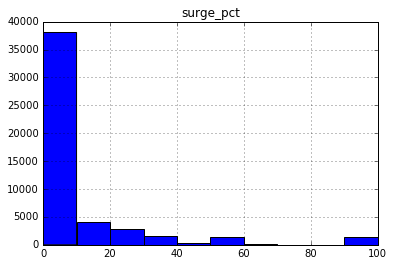

In [677]:
churn.hist('surge_pct');

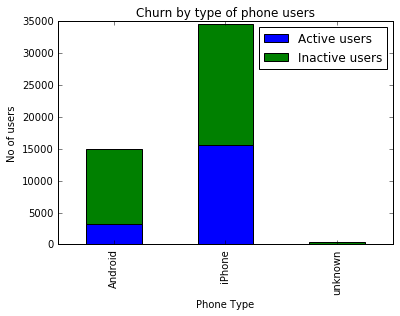

In [678]:
phone_data = churn.groupby(['phone','churn']).size().unstack()
my_plot = phone_data.plot(kind='bar',stacked=True,title="Churn by type of phone users")
my_plot.set_xlabel("Phone Type")
my_plot.set_ylabel("No of users")
my_plot.legend(["Active users","Inactive users"]);

#### As per the chart, a high percentage of Android users have churned. The company might want to look at the Android app to figure out why Android users are not as active as Iphone users.

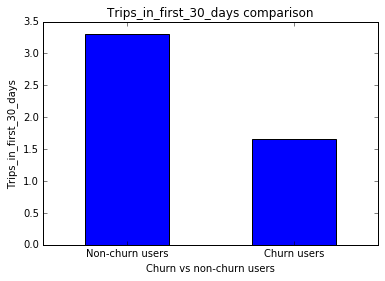

In [679]:
first_30_days = churn.groupby(['churn']).mean()['trips_in_first_30_days']
my_plot = first_30_days.plot(kind='bar',title="Trips_in_first_30_days comparison")
my_plot.set_xlabel("Churn vs non-churn users")
my_plot.set_ylabel("Trips_in_first_30_days")
my_plot.set_xticklabels(['Non-churn users','Churn users'],rotation=0);

** On average, active users made 3.3 trips in the first month, compared to 1.65 trips for a non active user. We can use this feature to predict if a user will churn or not in the future.**

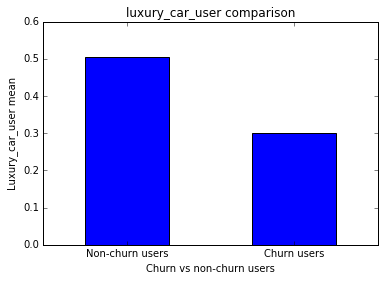

In [680]:
luxury_car_user = churn.groupby(['churn']).mean()['luxury_car_user']
my_plot = luxury_car_user.plot(kind='bar',title="luxury_car_user comparison")
my_plot.set_xlabel("Churn vs non-churn users")
my_plot.set_ylabel("Luxury_car_user mean")
my_plot.set_xticklabels(['Non-churn users','Churn users'],rotation=0);

** Luxury car users are more active(less churn) than regular car users.**

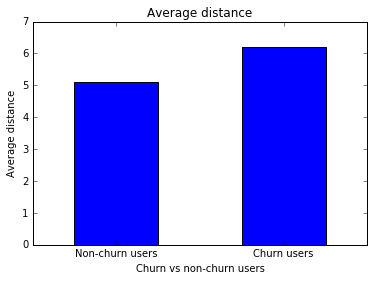

In [681]:
avg_dist = churn.groupby(['churn']).mean()['avg_dist']
my_plot = avg_dist.plot(kind='bar',title="Average distance")
my_plot.set_xlabel("Churn vs non-churn users")
my_plot.set_ylabel("Average distance")
my_plot.set_xticklabels(['Non-churn users','Churn users'],rotation=0);



#### The average distance of an active user is 5.11 miles compared to 6.20 miles of an inactive user. 

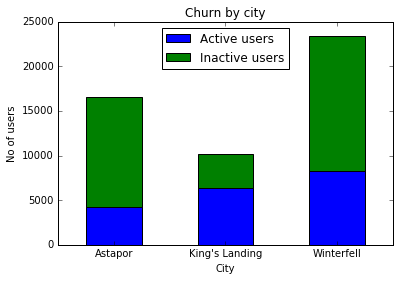

In [682]:
churn_bycity_data = churn.groupby(['city','churn']).size().unstack()
my_plot = churn_bycity_data.plot(kind='bar',stacked=True,title="Churn by city")
my_plot.set_xlabel("City")
my_plot.set_ylabel("No of users")
my_plot.set_xticklabels(['Astapor','King\'s Landing','Winterfell'],rotation=0);
my_plot.legend(["Active users","Inactive users"],loc='upper center');

#### King's Landing City has the highest ratio of active users compared to any other city.

### 3.Feature selection

In [683]:
#look at correlation between features.
churn.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
avg_dist,1.000000,0.079324,0.109990,-0.081491,-0.104414,-0.136329,0.032310,0.101652,0.092780
avg_rating_by_driver,0.079324,1.000000,0.081744,0.014790,0.023427,-0.043463,0.004533,0.017814,0.030769
avg_rating_of_driver,0.109990,0.081744,1.000000,-0.011388,-0.006915,-0.140080,-0.026131,-0.005720,0.115360
avg_surge,-0.081491,0.014790,-0.011388,1.000000,0.793582,-0.001841,-0.078791,-0.110071,0.003333
surge_pct,-0.104414,0.023427,-0.006915,0.793582,1.000000,0.005720,-0.106861,-0.144918,-0.011797
trips_in_first_30_days,-0.136329,-0.043463,-0.140080,-0.001841,0.005720,1.000000,0.112210,0.050388,-0.210463
luxury_car_user,0.032310,0.004533,-0.026131,-0.078791,-0.106861,0.112210,1.000000,0.035998,-0.205002
weekday_pct,0.101652,0.017814,-0.005720,-0.110071,-0.144918,0.050388,0.035998,1.000000,-0.009693
churn,0.092780,0.030769,0.115360,0.003333,-0.011797,-0.210463,-0.205002,-0.009693,1.000000


#### Notice a strong correlation between avg_surge and surge_pct. This makes sense as both these features are related. So we need to ignore one of the features while building the model.

#### Also we should ignore the feature last_trip_date in our model since we derive the target from this column. This will avoid leakage issues.

In [684]:
#Make the categorical variables as dummy
phone = pd.get_dummies(churn['phone'],drop_first=True)
churn = pd.concat([churn, phone], axis=1)

city = pd.get_dummies(churn['city'],drop_first=True)
churn = pd.concat([churn, city], axis=1)

churn.pop('avg_surge')
churn.pop('city')
churn.pop('last_trip_date')
churn.pop('phone')
churn.pop('signup_date')
y = churn.pop('churn').values



### 4.Model data

#### a) Run the logit function to check for feature significance

In [685]:
 #The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.
X_const = add_constant(churn, prepend=True)
logit_model = Logit(y, X_const).fit()

Optimization terminated successfully.
         Current function value: 0.554557
         Iterations 6


In [686]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49988
Method:                           MLE   Df Model:                           11
Date:                Tue, 24 Jan 2017   Pseudo R-squ.:                  0.1624
Time:                        18:19:52   Log-Likelihood:                -27728.
converged:                       True   LL-Null:                       -33106.
                                        LLR p-value:                     0.000
==========================================================================================
                             coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                      0.4870      0.128      3.812      0.000         0.237     0.737
avg_dist                   0.0341      0.002     16.327      0.000         0.030     0.038
avg_rating_by_driver       0.1535      0.023      6.766      0.000         0.109     0.198
avg_rating_of_driver       0.2302      0.014     16.789      0.000         0.203     0.257
surge_pct                 -0.0023      0.001     -4.314      0.000        -0.003    -0.001
trips_in_first_30_days    -0.1122      0.003    -32.600      0.000        -0.119    -0.105
luxury_car_user           -0.8688      0.021    -40.580      0.000        -0.911    -0.827
weekday_pct                0.0002      0.000      0.724      0.469        -0.000     0.001
iPhone                    -1.0788      0.025    -43.762      0.000        -1.127    -1.030
unknown                   -0.4825      0.118     -4.100      0.000        -0.713    -0.252
King's Landing            -1.7294      0.030    -58.287      0.000        -1.788    -1.671
Winterfell                -0.4997      0.024    -20.462      0.000        -0.548    -0.452
==========================================================================================
"""

#### Almost all features are significat as per the p value. Feature weekday_pct is not signififcant, but after removing it and running the model again, results didnot change. Hence we will keep all the above features.

#### b) Run logistic regression and use K folds validation to check model metrics.

In [687]:
#use kfolds for cross validation and report on accuracy, precision and recall
churn_arr = np.array(churn)
kfold = KFold(len(y),n_folds=5)

accuracies = []
precisions = []
recalls = []
for train_index, test_index in kfold:
    model = LogisticRegression()
    model.fit(churn_arr[train_index], y[train_index])
    y_predict = model.predict(churn_arr[test_index])
    y_true = y[test_index]
    accuracies.append(accuracy_score(y_true, y_predict))
    precisions.append(precision_score(y_true, y_predict))
    recalls.append(recall_score(y_true, y_predict))

print "accuracy:", np.round(np.average(accuracies),2)
print "precision:", np.round(np.average(precisions),2)
print "recall:", np.round(np.average(recalls),2)

accuracy: 0.72
precision: 0.74
recall: 0.85


#### c) Run randomforest

In [688]:
#sklearn's train_test_split to split into train and test set
X_train, X_test, y_train, y_test = train_test_split(churn, y)

In [689]:
#sklearn's RandomForestClassifier to build a model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Confusion matrix

In [690]:
#confusion matrix
y_predict = rf.predict(X_test)
print confusion_matrix(y_test, y_predict)

[[3274 1431]
 [1747 6048]]


In [691]:
print "accuracy:", np.round(rf.score(X_test, y_test),2)
print "precision:", np.round(precision_score(y_test, y_predict),2)
print "recall:", np.round(recall_score(y_test, y_predict),2)

accuracy: 0.75
precision: 0.81
recall: 0.78


In [692]:
#feature importance
feature_importances = np.argsort(rf.feature_importances_)
print "top five features:", list(churn.columns[feature_importances[-1:-6:-1]])

top five features: ['avg_dist', 'weekday_pct', 'avg_rating_by_driver', 'surge_pct', 'avg_rating_of_driver']


#### Find the right number of trees to model. In the below plot, accuracy is maximum at 175 trees.

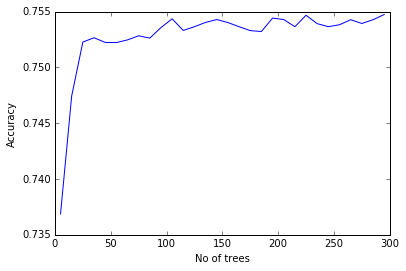

In [693]:
# 14. Try modifying the number of trees
num_trees = range(5, 300, 10)
accuracies = []
for n in num_trees:
    tot = 0
    for i in xrange(5):
        rf = RandomForestClassifier(n_estimators=n)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
plt.plot(num_trees, accuracies)
plt.xlabel('No of trees')
plt.ylabel('Accuracy')
plt.show()

#### Find the right number of max features to model. As per the below plot this number is 9.

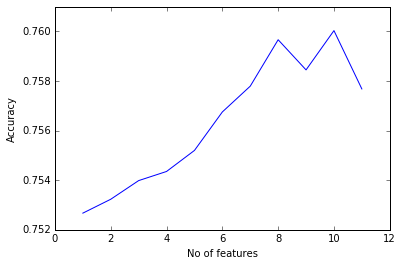

In [694]:
num_features = range(1, len(churn.columns) + 1)
accuracies = []
for n in num_features:
    tot = 0
    for i in xrange(5):
        rf = RandomForestClassifier(max_features=n,n_estimators=175)
        rf.fit(X_train, y_train)
        tot += rf.score(X_test, y_test)
    accuracies.append(tot / 5)
plt.plot(num_features, accuracies)
plt.xlabel('No of features')
plt.ylabel('Accuracy')
plt.show()

#### d) Try other models that are available.

In [695]:
def get_scores(classifier, X_train, X_test, y_train, y_test, **kwargs):
    model = classifier(**kwargs)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    return model.score(X_test, y_test), \
           precision_score(y_test, y_predict), \
           recall_score(y_test, y_predict)



print "    Model,        Accuracy,          Precision,            Recall"
print "    Random Forest:", get_scores(RandomForestClassifier, X_train, X_test, y_train, y_test, n_estimators=175, max_features=9, random_state =1)
print "    Logistic Regression:", get_scores(LogisticRegression, X_train, X_test, y_train, y_test)
print "    Decision Tree:", get_scores(DecisionTreeClassifier, X_train, X_test, y_train, y_test)
print "    SVM:", get_scores(SVC, X_train, X_test, y_train, y_test)
print "    Naive Bayes:", get_scores(MultinomialNB, X_train, X_test, y_train, y_test)

    Model,        Accuracy,          Precision,            Recall
    Random Forest: (0.75863999999999998, 0.80065441731688902, 0.81616420782552923)
    Logistic Regression: (0.72255999999999998, 0.74170483744832982, 0.85169980756895447)
    Decision Tree: (0.70864000000000005, 0.76591112818542706, 0.76728672225785766)
    SVM: (0.76368000000000003, 0.78867024448419798, 0.84836433611289286)
    Naive Bayes: (0.64824000000000004, 0.69945996712843395, 0.76433611289288006)


 **Randomforest and SVM(Support Vector Machines) have the best result. We chose Ramdomforest since it is faster and will perform better with larger datasets.**

### 5. Find the right threshold

** From a business perspective, the impact would be high when a potential churn is predicted incorrectly as no-churn (False Negative). There is also a loss when we incorrectly predict a user as churn (False Positive).This could be because the ride sharing company might incentivize a user to not leave by offering some promotions. If we incorrectly predict churn, the company tends to lose money on promotions to users who would have stayed anyway.**

** For a business, a lost customer might be a bigger loss than money lost on promotions. So in this case False Negative(FN) might be slightly more important than False Positive(FP). So we will give more weightage to TPR in the ROC curve than FPR.**

In [696]:
#bulid ROC curve
rf = RandomForestClassifier(n_estimators = 175,max_features = 9)
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)

In [697]:
auc = metrics.auc(fpr,tpr)
print "AUC:",np.round(auc,2)

AUC: 0.74


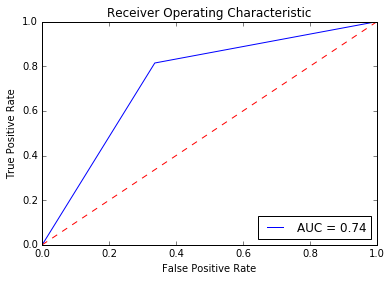

In [698]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

** We can agree on a threshold of 0.5 since TPR is slightly more more important than FPR.**

## 6. Conclusions and recommendations

 ** 1.We saw that a high percentage of Android users have churned compared to iPhone users. The company might want to look at their Android app to figure out why Android users are not as active as Iphone users.**
 
 ** 2.The company should look at the number of trips taken in the first 30 days by the customer. If the number of trips average at 3.3 and higher, there is a good chance that this user will be an active user. This feature allows us the company to predict if a customer will churn or not in the future.**
 
 **3.The active users tend to use the luxury car more than inactive users. The company can focus more can luxury car services and see if it improves retention.**
 
 **4.King's landing city has a higher ratio of active users. The company should look at the reasons and figure out if the same active users ratio can be increased in the other 2 cities.**